<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/Tomato-With%20TF.Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salarshafiee71","key":"034b1bfa039be380c7e1fd1f9710df35"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
!kaggle datasets download -d noulam/tomato -p /content

Dataset URL: https://www.kaggle.com/datasets/noulam/tomato
License(s): copyright-authors
 97% 721M/743M [00:10<00:00, 111MB/s]
100% 743M/743M [00:10<00:00, 74.0MB/s]


In [6]:
!unzip -q /content/tomato.zip -d /content/tomato

In [7]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model  # Corrected 'model' to 'Model'
# from tensorflow.keras.applications.inception_v3 import InceptionV3  # Example commented out
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob  # Corrected a typo: 'glob.' to 'glob'

In [8]:
IMG_SIZE=[224,224]
train_path='/content/tomato/New Plant Diseases Dataset(Augmented)/train'
valid_path='/content/tomato/New Plant Diseases Dataset(Augmented)/valid'
BATCH_SIZE=16

In [9]:
import tensorflow as tf

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 18345 files belonging to 10 classes.


In [11]:
Valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4585 files belonging to 10 classes.


In [12]:
class_names = train_dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [13]:
val_batches = tf.data.experimental.cardinality(Valid_dataset)
test_dataset = Valid_dataset.take(val_batches // 5)
Valid_dataset = Valid_dataset.skip(val_batches // 5)

In [14]:
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=287>

In [15]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(Valid_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 230
Number of test batches: 57


Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
Valid_dataset = Valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [17]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [18]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [19]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + [3]
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = False

Important note about BatchNormalization layers
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the Transfer learning guide.

In [21]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [44]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(16, 10)


In [25]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [50]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [51]:
history=model.fit(train_dataset,validation_data=Valid_dataset,epochs=10)

Epoch 1/10
1147/1147 [==============================] - 96s 82ms/step - loss: 1.0693 - sparse_categorical_accuracy: 0.6619 - val_loss: 0.5095 - val_sparse_categorical_accuracy: 0.8255
Epoch 2/10
1147/1147 [==============================] - 93s 81ms/step - loss: 0.5940 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.4169 - val_sparse_categorical_accuracy: 0.8598
Epoch 3/10
1147/1147 [==============================] - 93s 81ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.8225 - val_loss: 0.4151 - val_sparse_categorical_accuracy: 0.8503
Epoch 4/10
1147/1147 [==============================] - 93s 81ms/step - loss: 0.5050 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.3514 - val_sparse_categorical_accuracy: 0.8843
Epoch 5/10
1147/1147 [==============================] - 94s 81ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.3907 - val_sparse_categorical_accuracy: 0.8669
Epoch 6/10
1147/1147 [==============================] - 94s 82ms/step - loss: 0.

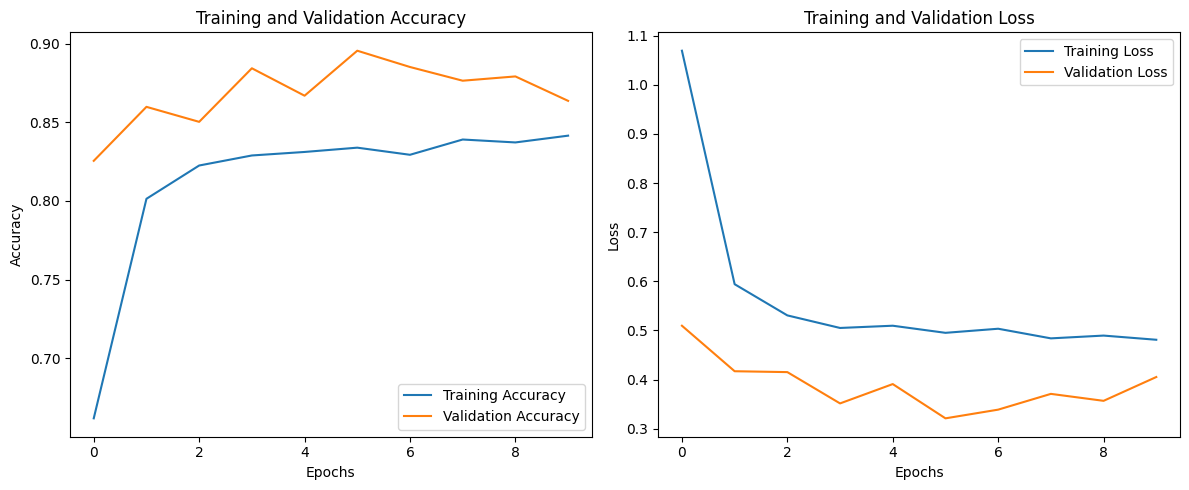

In [52]:
import matplotlib.pyplot as plt

# Extract metrics
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [55]:
import numpy as np

# Get predictions for the test dataset
predictions = model.predict(test_dataset)

# If you need probabilities, use tf.nn.softmax (for logits)
predicted_probabilities = tf.nn.softmax(predictions).numpy()

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted_probabilities, axis=-1)

# Collect true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


57/57 [==============================] - 4s 66ms/step


In [56]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

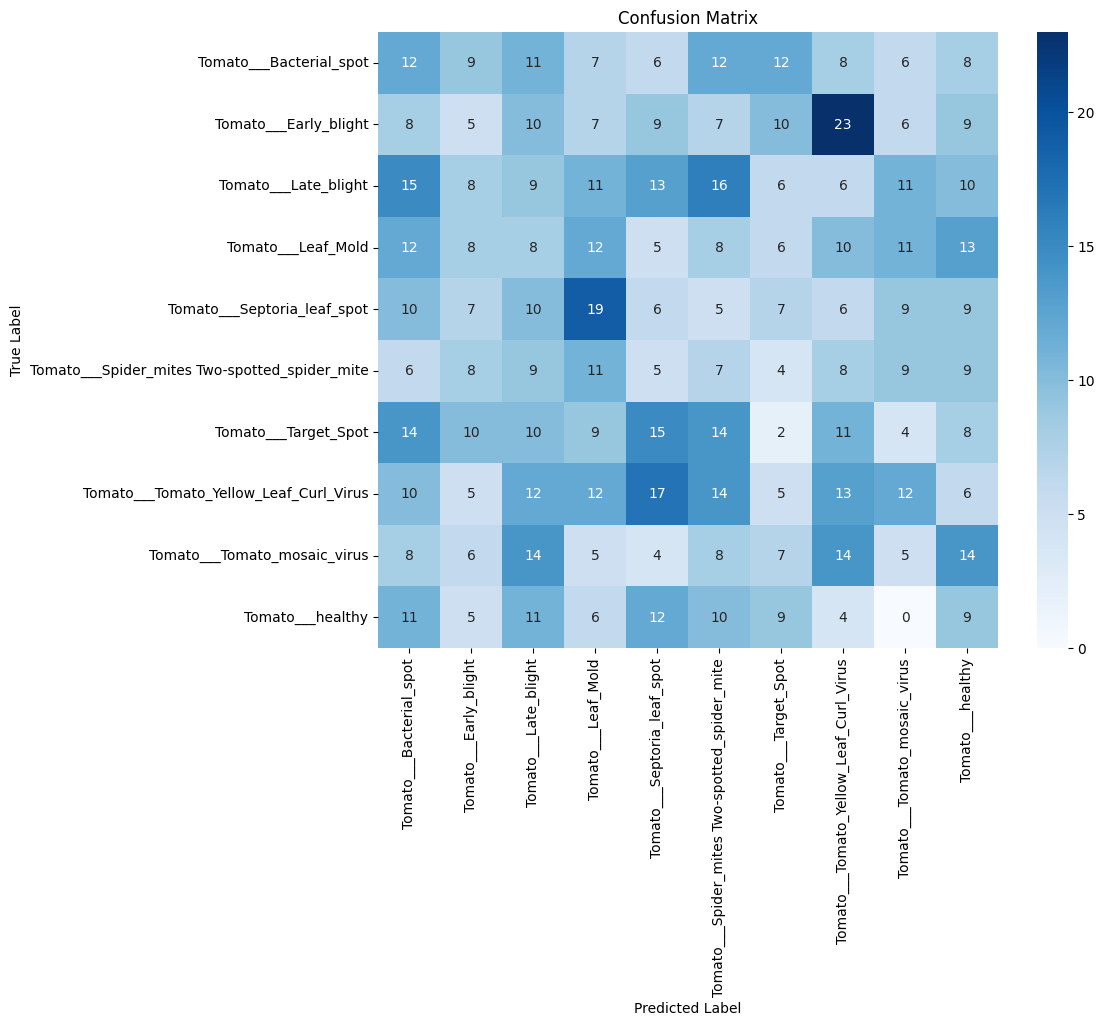

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names =class_names

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Save the entire model
model.save('path_to_my_model.h5')  # Save as HDF5 file

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
